In [34]:
import torch
import torchvision

import torch.utils.tensorboard as tb
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from PIL import Image

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from os import path
import time
import copy
from tqdm import tqdm

LABEL_NAMES = {'background':0, 'kart':1, 'pickup':2, 'nitro':3, 'bomb':4, 'projectile':5}

LABEL_=['background','kart','pickup','nitro','bomb','projectile']

## Defining Torch Dataset

In [4]:
class SuperTuxDataset(Dataset):
    def __init__(self, image_path,data_transforms=None):
        """
        Your code here
        Hint: Use the python csv library to parse labels.csv
        """
        
        self.df = pd.read_csv(path.join(image_path,'labels.csv'), header=0)
        self.path = image_path
        self.files = self.df.iloc[:,0].values
        self.labels = self.df.iloc[:,1].astype('category').cat.codes.values
        self.tracks = self.df.iloc[:,2].values
        
        if data_transforms is None:
            self.transform = torchvision.transforms.Compose([
                          torchvision.transforms.ToTensor()
            ])
        else:
            self.transform = data_transforms
        
        
    def __len__(self):
        """
        Your code here
        """
        return len(self.files)

    def __getitem__(self, idx):
        """
        Your code here
        return a tuple: img, label
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.files[idx]
        image = self.transform(Image.open(path.join(self.path,img_name)))
        label = self.labels[idx]
        sample = (image, label)
        return sample

The following utility visualizes the data, optionally, as a sanity check for your implementation of the dataset class. Call visualize_data() after setting the correct variables inside this code snippet. 

In [5]:
def visualize_data():

    Path_to_your_data= 'data/train/'
    dataset = SuperTuxDataset(image_path=Path_to_your_data)

    f, axes = plt.subplots(3, len(LABEL_NAMES))

    counts = [0]*len(LABEL_NAMES)

    for img, label in dataset:
        c = counts[label]

        if c < 3:
            ax = axes[c][label]
            ax.imshow(img.permute(1, 2, 0).numpy())
            ax.axis('off')
            ax.set_title(LABEL_[label])
            counts[label] += 1
        
        if sum(counts) >= 3 * len(LABEL_NAMES):
            break

    plt.show()

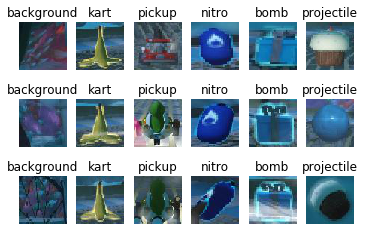

In [6]:
visualize_data()

## Defining Model Architecture and Loss

In [7]:
class ClassificationLoss(torch.nn.Module):
    def forward(self, inputs, target):
        """
        Your code here
        Compute mean(-log(softmax(input)_label))
        @input:  torch.Tensor((B,C)), where B = batch size, C = number of classes
        @target: torch.Tensor((B,), dtype=torch.int64)
        @return:  torch.Tensor((,))
        Hint: Don't be too fancy, this is a one-liner
        """
        X = torch.exp(inputs)/torch.exp(inputs).sum(axis=1).reshape(-1,1)
        Y = -torch.log(X[torch.arange(len(target)),target.long()])
        loss = torch.sum(Y)/len(target)
        return loss


class CNNClassifier(torch.nn.Module):
    def __init__(self):
        """
        Your code here
        (n+2p-k)/s+1
        """
        super(CNNClassifier,self).__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(3,6,kernel_size=3,stride=1,padding=1),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2,2),
            torch.nn.BatchNorm2d(6),
            torch.nn.Conv2d(6,12,kernel_size=3,stride=1,padding=1),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2,2),
            torch.nn.BatchNorm2d(12),
            torch.nn.Conv2d(12,24,kernel_size=3,stride=1,padding=1),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(24,24,kernel_size=3,stride=1,padding=1),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(24,20,kernel_size=3,stride=1,padding=1),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2,2),
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(1280,400),
            torch.nn.ReLU(True),
            torch.nn.Dropout2d(0.15),
            torch.nn.Linear(400,100),
            torch.nn.ReLU(True),
            torch.nn.Dropout2d(0.15),
            torch.nn.Linear(100,6)
        )

    def forward(self, x):
        """
        Your code here
        @x: torch.Tensor((B,3,64,64))
        @return: torch.Tensor((B,6))
        """
        out = self.conv(x)
        out = out.view(out.size(0),-1)
        out = self.fc(out)
        return out

In [45]:
from torch import save
from torch import load
from os import path

def save_model(model):
    return save(model.state_dict(), path.join( 'cnn.th'))


def load_model():
    r = CNNClassifier()
    r.load_state_dict(load('cnn.th', map_location='cpu'))
    return r

## Tensorboard logging

In [9]:
def test_logging(train_logger, valid_logger):

    """
    Your code here.
    Finish logging the dummy loss and accuracy
    Log the loss every iteration, the accuracy only after each epoch
    Make sure to set global_step correctly, for epoch=0, iteration=0: global_step=0
    Call the loss 'loss', and accuracy 'accuracy' (no slash or other namespace)
    """
    global_step = 0
    size_train = 20
    size_valid = 10
    for epoch in range(10):
        torch.manual_seed(epoch)
        train_acc = []
        valid_acc = []
        for iteration in range(size_train):
            dummy_train_loss = 0.9**(epoch+iteration/20.)
            dummy_train_accuracy = epoch/10. + torch.randn(10)
            train_logger.add_scalar('train loss',
                                    dummy_train_loss,
                                    global_step)
            train_acc.append(torch.mean(dummy_train_accuracy))
            global_step += 1
        
        train_acc_iter = torch.mean(torch.FloatTensor(train_acc))
        train_logger.add_scalar('train accuracy',
                                train_acc_iter,
                                epoch)
        
        torch.manual_seed(epoch)
        for iteration in range(size_valid):
            dummy_validation_accuracy = epoch / 10. + torch.randn(10)
            valid_acc.append(torch.mean(dummy_validation_accuracy))
            
        valid_acc_iter = torch.mean(torch.FloatTensor(valid_acc))
        valid_logger.add_scalar('valid accuracy',
                                valid_acc_iter,
                                epoch)

After implementing `test_logging()`, call it below. This should produce some plots on your tensorboard.

In [9]:
%load_ext tensorboard

In [10]:
%reload_ext tensorboard

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from torch.utils.tensorboard import SummaryWriter
ROOT_LOG_DIR = './log_test'

In [11]:
%tensorboard --logdir {ROOT_LOG_DIR} --host=127.0.0.1 --port 7777 #Launch tensorboard

Reusing TensorBoard on port 7777 (pid 8256), started 0:17:01 ago. (Use '!kill 8256' to kill it.)

In [12]:
train_logger = tb.SummaryWriter(path.join(ROOT_LOG_DIR, 'train'))
valid_logger = tb.SummaryWriter(path.join(ROOT_LOG_DIR, 'test'))
test_logging(train_logger, valid_logger)

**Training and evaluation utility functions** 

Here are some implementations of useful functions for training and evaluating your models. Read these carefully. You may need to make some obvious edits before these will work.

In [22]:
def accuracy(outputs, labels):
    outputs_idx = outputs.max(1)[1].type_as(labels)
    return outputs_idx.eq(labels).float().mean()

def predict(model, inputs, device='cpu'):
    inputs = inputs.to(device)
    logits = model(inputs)
    return F.softmax(logits, -1)

def draw_bar(axis, preds, labels=None):
    y_pos = np.arange(6)
    axis.barh(y_pos, preds, align='center', alpha=0.5)
    axis.set_xticks(np.linspace(0, 1, 10))

    if labels:
        axis.set_yticks(y_pos)
        axis.set_yticklabels(labels)
    else:
        axis.get_yaxis().set_visible(False)

    axis.get_xaxis().set_visible(False)

def visualize_predictions():
  
    model = load_model()
    model.eval()

    validation_image_path='data/valid/' #enter the path 

    dataset = SuperTuxDataset(image_path=validation_image_path)

    f, axes = plt.subplots(2, 6)

    idxes = np.random.randint(0, len(dataset), size=6)

    for i, idx in enumerate(idxes):
        img, label = dataset[idx]
        preds = predict(model, img[None], device='cpu').detach().cpu().numpy()

        axes[0, i].imshow(TF.to_pil_image(img))
        axes[0, i].axis('off')
        draw_bar(axes[1, i], preds[0], LABEL_ if i == 0 else None)

    plt.show()

## Training models

The `load_data` utility below uses your implementation of the dataset class above to provide a helper function that might be useful when you train your models. You won't need to change anything inside this function. 



In [23]:
def load_data(dataset_path, data_transforms=None, num_workers=0, batch_size=128):
    dataset = SuperTuxDataset(dataset_path,data_transforms)
    return DataLoader(dataset, num_workers=num_workers, batch_size=batch_size, shuffle=True)

But you *will* need to implement `train()`, which takes an `args` object, that could have arbitrary arguments inside. We won't test your train function directly, but will instead evaluate the model it produces as output. To call `train`, you have to first create an args object, and add various attributes to it, as shown below:

In [37]:
class Args(object):
    def  __init__(self):
        self.learning_rate = 0.005
        self.momentum = 0.9
        self.step_size = 5
        self.gamma = 0.5
        self.log_dir = './logdir'
        self.epoch = 3
        self.data_dir = 'data'
        self.data_transforms = {
            'train': torchvision.transforms.Compose([
                torchvision.transforms.RandomHorizontalFlip(),
                torchvision.transforms.ToTensor()
            ]),
            'valid': torchvision.transforms.Compose([
                torchvision.transforms.ToTensor()
            ]),
      }

args = Args();
# Add attributes to args here, such as:
# args.learning_rate = 0.0001
# args.log_dir = './my_tensorboard_log_directory' 

Then implement `train`. Follow the instructions in the assignment.

In [46]:
def train(args):
    data_transforms = args.data_transforms
    data_dir = args.data_dir
    
    image_datasets = {x: SuperTuxDataset(path.join(data_dir, x),
                                         data_transforms[x])
                      for x in ['train', 'valid']}
    dataloaders = {x: DataLoader(image_datasets[x], 
                                 batch_size=64,
                                 shuffle=True)
                  for x in ['train', 'valid']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    since = time.time()
    
    model = CNNClassifier().to(device)
    # model = load_model()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    num_epochs=args.epoch
    criterion = ClassificationLoss()
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=args.learning_rate,
                                momentum = args.momentum)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                        step_size = args.step_size,
                                        gamma = args.gamma)
    
    global_step_train = 0
    global_step_valid = 0
    
    if args.log_dir is not None:
        train_logger = tb.SummaryWriter(path.join(args.log_dir, 'train'))
        valid_logger = tb.SummaryWriter(path.join(args.log_dir, 'valid'))
    
    for epoch in range(num_epochs):
        print('\nEpoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase],position=0):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, axis=1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                if phase == 'train':
                    train_logger.add_scalar('train loss',
                                            loss.item(),
                                            global_step_train)
                    global_step_train += 1
                elif phase == 'valid':
                    valid_logger.add_scalar('valid loss',
                                            loss.item(),
                                            global_step_valid)
                    global_step_valid += 1
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_logger.add_scalar('train accuracy',
                                        epoch_acc,
                                        epoch)
            elif phase == 'valid':
                valid_logger.add_scalar('valid accuracy',
                                        epoch_acc,
                                        epoch)

            print('\n{} Loss: {:.4f} Acc: {:.4f}\n'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    save_model(model)

Now, you can call `train` with `train(args)`, where `args` contains your various favorite settings of hyperparameters and other arguments that your implementation of `train` needs.


Afterwards, you can call `predict()' and `visualize_predictions()' to evaluate your model.

In [48]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [49]:
%reload_ext tensorboard

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ROOT_LOG_DIR = './logdir'
%tensorboard --logdir {ROOT_LOG_DIR} --host=127.0.0.2 --port 1000

Reusing TensorBoard on port 1000 (pid 8), started 0:22:12 ago. (Use '!kill 8' to kill it.)

In [47]:
args = Args()
train(args)

  0%|                                                                                          | 0/329 [00:00<?, ?it/s]


Epoch 1/3
----------


  0%|                                                                                          | 0/141 [00:00<?, ?it/s]


train Loss: 1.2496 Acc: 0.4914



  0%|                                                                                          | 0/329 [00:00<?, ?it/s]


valid Loss: 1.0738 Acc: 0.6472


Epoch 2/3
----------


  0%|                                                                                          | 0/141 [00:00<?, ?it/s]


train Loss: 0.5017 Acc: 0.8260



  0%|                                                                                          | 0/329 [00:00<?, ?it/s]


valid Loss: 0.5492 Acc: 0.8104


Epoch 3/3
----------


  0%|                                                                                          | 0/141 [00:00<?, ?it/s]


train Loss: 0.3354 Acc: 0.8847



100%|████████████████████████████████████████████████████████████████████████████████| 141/141 [00:32<00:00,  4.38it/s]


valid Loss: 0.4833 Acc: 0.8487

Training complete in 7m 26s
Best valid Acc: 0.848667


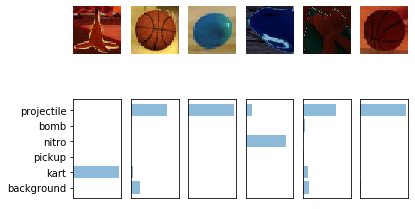

In [35]:
visualize_predictions()